In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import torch
import time
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

from bimmquant.utils import tools
from bimmquant.models.bimm2d import BIMM2D
from bimmquant.data.dataset_from_3d_npy import DatasetFor2Dmodel

In [2]:
#Set random seed
random_seed = 123
torch.manual_seed(random_seed)

In [3]:
%load_ext tensorboard

# Quantification and segmentation using the 2D BIMM - *artificial data*

In this notebook, we fit the blurred interface mixture model (BIMM) to a 3D artificial dataset generated by the notebook `examples/art_data_generation.ipynb` - make sure to run this before continuing this tutorial. This dataset is generated in the same way as the artificial datasets described in [our paper](https://arxiv.org/abs/2009.07218) [1]. We compare the fitted model parameterts with the parameters used to generate the artificial data (ground truth), and use the fitted model to find the rigth threshold for segmentation.

Note that the results for the quantification might not be as close to the ground truth values as reported in the paper. This is because we here only run the code once, while for the paper, the code was run 30 times to calculate confidence intervals, and the average of these 30 runs is reported as the final results.

[1] Brenne, E. O., Dahl, V. A., & Jørgensen, P. S. (2020). *A Physical Model for Microstructural Characterization and Segmentation of 3D Tomography Data*. [arXiv:2009.07218](https://arxiv.org/abs/2009.07218).


## Workflow:

1. Load data and ground truth parameters (GT)
2. Investigate 1D and 2D histograms 
3. Fit the 2D BIMM
4. Quantification: Compare to ground truth values
5. Segmentation


## 1. Load data and ground truth parameters (GT)

Before running this tutorial, make sure that the notebook `examples/art_data_generation.ipynb` has been run to generate the dataset `example_data/artificial_data/art_data_2phases.npy`.
 

Dataset shape:  [298, 298, 48]


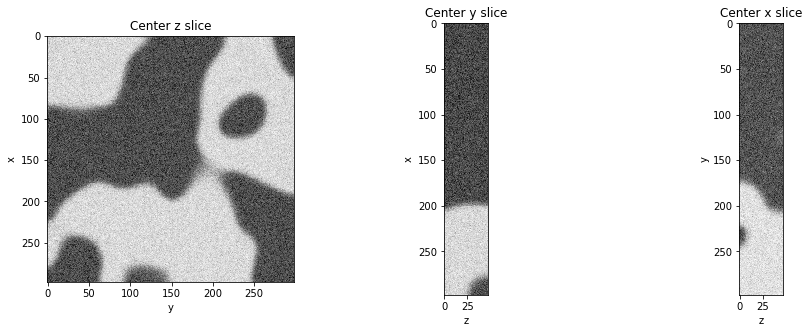

In [4]:
data_path = os.path.join('example_data', 'artificial_data', 'art_data_2phases.npy')
dataset = DatasetFor2Dmodel(data_path)
print('Dataset shape: ', dataset.shape)
tools.plot_center_slices(dataset.u.reshape(dataset.shape))

In [5]:
ground_truth_dict_path = os.path.join('example_data', 'artificial_data', 'art_data_2phases_GT.json')
ground_truth_dict = json.load( open( ground_truth_dict_path ) )

for key in ground_truth_dict:
    print(key, ground_truth_dict[key])


I [0.1, 0.9]
sigma_b 3.0
sigma_n 0.1
V [0.49250422222222223, 0.5074957777777778]
A_per_volume 0.01745909548611111


## 2. Investigate 1D and 2D histograms 

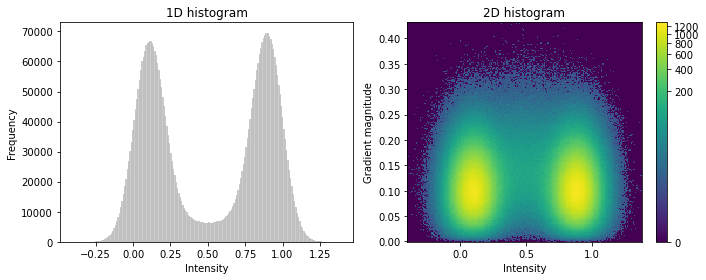

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
_ = tools.plot_1D_histogram(dataset.u.numpy(), bins = 200, fig_external = [fig, ax[0]],
                            xlabel='Intensity', title='1D histogram')
_ = tools.plot_2D_histogram(dataset.u.numpy(), dataset.v.numpy(), bins = 200, fig_external = [fig, ax[1]], 
                            title='2D histogram')

# 3. Fit the 2-D BIMM

* n_ints: Number of iterations of optimization algoritm
* batch_size: number of datapoints per iteration
* nMC: Number of samples in Monte Carlo integration

Example: The following parameters takes approx. 3 minutes: 
```
n_its = 2000, batch_size = 50, nMC = 1000
```

In [7]:
n_its = 2000
batch_size = 50
nMC = 1000

n_phases = 2

In [8]:
############
## MODEL  ##
############

model = BIMM2D(n_phases)

In [9]:
print('Initial parameters:\n ')
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Initial parameters:
 
I 	 tensor([0., 1.])
sigma_b 	 tensor(2.)
sigma_n 	 tensor(0.1000)
d 	 tensor(2.)
W 	 tensor([0., 0., 0.])
r 	 tensor(0.)


In [10]:
################
## OPTIMIZER  ##
################

optimizer = torch.optim.Adadelta(model.parameters()) #DEFAULTS: lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)

In [11]:
###########
## DATA  ##
###########

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = True)

In [12]:
#####################
## TENSORBOARD LOG ##
#####################

logcomment = 'art_data_2phases_test1'


timestamp = datetime.now().strftime("%b%d_%H-%M-%S-%f")
params_string = f' nMC={nMC} batch_size={batch_size} its={n_its} '
logfile = timestamp + params_string + ' comment=' + logcomment

logfile_path = os.path.join('example_log_artificial', logfile)

writer = SummaryWriter(log_dir=logfile_path)

In [13]:
##############
## FITTING  ##
##############

t_start_total = time.time()

for it, batch in enumerate(data_loader):
    t_start_it = time.time()

    #Log to tensorboard
    log_dict = tools.get_log_dict(model)
    tools.tb_log(writer, log_dict, it)

    loss = model(batch[0], batch[1], nMC)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    #Log to tensorboard
    writer.add_scalar('loss/loss', loss, it)
    writer.flush()

    print('it:', it, 'of', n_its, 'its, %.3f s = %.2f min  total:  %.3f s = %.2f min '%( (time.time()-t_start_it), (time.time()-t_start_it)/60,(time.time()-t_start_total), (time.time()-t_start_total)/60),  end="\r")


    if torch.isnan(loss):
        print('Loss is NaN!')
        break

    if it>=n_its:
        break


In [14]:
print('Final parameters:\n ')
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Final parameters:
 
I 	 tensor([0.1025, 0.8957])
sigma_b 	 tensor(2.8917)
sigma_n 	 tensor(0.1018)
d 	 tensor(2.4299)
W 	 tensor([ 0.0823,  0.1432, -0.3965])
r 	 tensor(0.0347)


## View optimization progress to judge convergence

If no convergence is seen, different otpimization parameters should be tried.


In [15]:
%tensorboard --logdir=example_log_artificial

### Find average of last iterations

In [16]:
sorted(os.listdir('example_log_artificial'))

['Oct12_14-01-49-911809 nMC=1000 batch_size=50 its=2000  comment=art_data_2phases_test1']

In [17]:
#choose the run you want to use for quantification and segmentation:
logfile_path = os.path.join('example_log_artificial', sorted(os.listdir('example_log_artificial'))[-1])

#get the mean of the last iterations:
nvals_mean = 500
avg_dict, std_dict = tools.get_mean_lastvals(logfile_path, nvals_mean)
avg_dict_formated = tools.log_to_params_dict(avg_dict)
print('Final fitted parameters:')
avg_dict_formated

Final fitted parameters:


{'I': tensor([0.1013, 0.8965]),
 'w': tensor([0.3726, 0.3946, 0.2328]),
 'sigma_n': tensor(0.1018),
 'd': tensor(2.4161),
 'sigma_b': tensor(2.8596),
 'rho': tensor(0.0352)}

### Plot model VS 2D histogram

In [ ]:
model.set_params(avg_dict_formated)

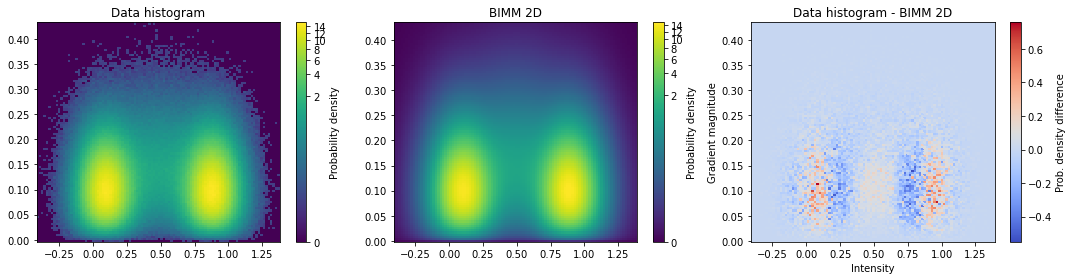

In [23]:
u_plot, v_plot = dataset.u.numpy(), dataset.v.numpy()
Ivals=np.linspace(np.min(u_plot), np.max(u_plot), 100)
Gvals=np.linspace(np.min(v_plot), np.max(v_plot), 100)
dI=Ivals[1]-Ivals[0]
dG=Gvals[1]-Gvals[0]

fig, ax = plt.subplots(1, 3, figsize = (15,4))

nbins_adj = np.concatenate([Ivals, np.array([(Ivals[-1]+dI)])])-0.5*dI, np.concatenate([Gvals, np.array([(Gvals[-1]+dG)])])-0.5*dG
im_data_hist = tools.plot_2D_histogram(u_plot, v_plot, cmap_gamma=0.2, fig_external = [fig, ax[0]],
                                       bins=nbins_adj, title='Data histogram', xlabel='Intensity', 
                                       ylabel='Gradient magnitude', cbar_label='Probability density', density=True)

im_model_eval = tools.plot_2D_gridplot(model, Ivals, Gvals, n_MC_components=10000,  fig_external = [fig, ax[1]], cmap='viridis',
                       cmap_gamma=0.2, title='BIMM 2D', xlabel='Intensity', 
                                       ylabel='Gradient magnitude', cbar_label='Probability density',axis='on')

tools.plot_2D_image(im_data_hist[0] - im_model_eval.T, cmap='coolwarm', colorbar =True,# vmin=-30, vmax=30, 
                    fig_external = [fig, ax[2]], xvals=Ivals, yvals=Gvals,
                    title='Data histogram - BIMM 2D',
                   xlabel='Intensity', ylabel='Gradient magnitude', cbar_label='Prob. density difference')


# 4. Comparison to ground truth values

Parameters used to generate the artificial data are compared to fitted model parameters


In [18]:
V1, V2 = tools.get_V(avg_dict)

print(' Volume fractions: \n')
print('Model estimate:')
print('Pores (black):              %.3f \nSolid material (white):     %.3f \n  '%(V1, V2))
print('Ground truth:')
print('Pores (black):              %.3f \nSolid material (white):     %.3f \n  '%(ground_truth_dict['V'][0], ground_truth_dict['V'][1]))

voxelsize = 1 
A12 = tools.get_A(avg_dict, voxelsize)

print('\n Interface area per volume (voxel²/voxel³):\n')
print('Model estimate:')
print(' %.4f \n '%(A12))
print('Ground truth:')
print(' %.4f \n '%(ground_truth_dict['A_per_volume']))

print('\n Phase intensities:\n')
print('Model estimate:')
print('Pores (black):              %.3f \nSolid material (white):     %.3f \n  '%(avg_dict_formated['I'][0], avg_dict_formated['I'][1]))
print('Ground truth:')
print('Pores (black):              %.3f \nSolid material (white):     %.3f \n  '%(ground_truth_dict['I'][0], ground_truth_dict['I'][1]))

print('\n Noise (standard deviation of added Gaussian noise):\n')
print('Model estimate:')
print('sigma_n =   %.3f \n  '%(avg_dict_formated['sigma_n']))
print('Ground truth:')
print('sigma_n =   %.3f \n  '%(ground_truth_dict['sigma_n']))


print('\n Blurr (standard deviation of applied Gaussian filter):\n')
print('Model estimate:')
print('sigma_b =   %.3f \n  '%(avg_dict_formated['sigma_b']))
print('Ground truth:')
print('sigma_b =   %.3f \n  '%(ground_truth_dict['sigma_b']))



 Volume fractions: 

Model estimate:
Pores (black):              0.489 
Solid material (white):     0.511 
  
Ground truth:
Pores (black):              0.493 
Solid material (white):     0.507 
  

 Interface area per volume (voxel²/voxel³):

Model estimate:
 0.0168 
 
Ground truth:
 0.0175 
 

 Phase intensities:

Model estimate:
Pores (black):              0.101 
Solid material (white):     0.897 
  
Ground truth:
Pores (black):              0.100 
Solid material (white):     0.900 
  

 Noise (standard deviation of added Gaussian noise):

Model estimate:
sigma_n =   0.102 
  
Ground truth:
sigma_n =   0.100 
  

 Blurr (standard deviation of applied Gaussian filter):

Model estimate:
sigma_b =   2.860 
  
Ground truth:
sigma_b =   3.000 
  


# 5. Segmentation of a small data volume

Here, we perform a simple maximum-probability segmentation. That is, each voxels is classified according to which phase it has the highest probability to belong to, according to the model. This corresponds to thresholding in the 2D intensity - gradient magnitude space.


NB! Here, we only chose a small region of the data for segmentation to not fill up the RAM of a small computer. To segment the whole volume, a slice-by-slice or small cube-by-cube approach is recommended.




In [19]:
model.set_params(avg_dict_formated)

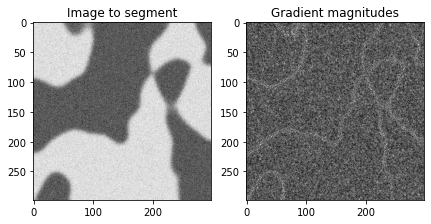

In [20]:
slice_no = 5
image_to_segment_u = np.reshape(dataset.u, dataset.shape)[:,:,slice_no]
image_to_segment_v = np.reshape(dataset.v, dataset.shape)[:,:,slice_no]
imsize_x, imsize_y = image_to_segment_u.shape

fig, ax = plt.subplots(1, 2, figsize = (7,5))
ax[0].imshow(image_to_segment_u, cmap='Greys_r')
ax[0].set_title('Image to segment')
ax[1].imshow(image_to_segment_v, cmap='Greys_r')
ax[1].set_title('Gradient magnitudes')
plt.show()


 Interface labels re-assigned to interior class accordint to image intensity: 



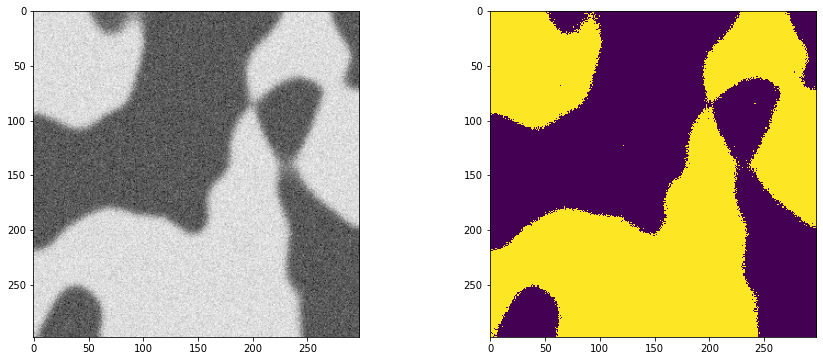

In [25]:
nMC_eval = 50
labeled_image = tools.evaluate_log_prob(model, image_to_segment_u, image_to_segment_v,  nMC_eval, n_labels = 2)

print('\n Interface labels re-assigned to interior class accordint to image intensity: \n')

fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].imshow(image_to_segment_u, cmap='Greys_r')
ax[1].imshow(labeled_image, cmap='viridis', interpolation='none')
plt.show()

### Scatter plot voxels to illustrate how labels are determined

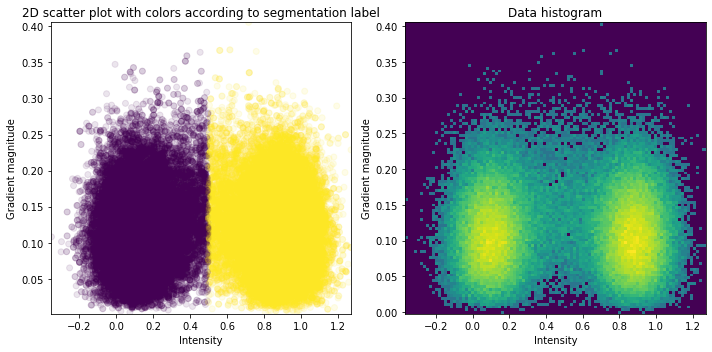

In [26]:
u_plot, v_plot = image_to_segment_u.numpy().ravel(), image_to_segment_v.numpy().ravel()
Ivals=np.linspace(np.min(u_plot), np.max(u_plot), 100)
Gvals=np.linspace(np.min(v_plot), np.max(v_plot), 100)
dI=Ivals[1]-Ivals[0]
dG=Gvals[1]-Gvals[0]

fig, ax = plt.subplots(1, 2, figsize = (10,5))
_ = tools.plot_2D_scatter_plot(u_plot, v_plot, colors = labeled_image.ravel(), 
                               n_samples = 100000, alpha = 0.1, xlim = [Ivals[0], Ivals[-1]], ylim = [Gvals[0], Gvals[-1]], fig_external = [fig, ax[0]],
                               xlabel='Intensity',ylabel='Gradient magnitude', title='2D scatter plot with colors according to segmentation label')

nbins_adj = np.concatenate([Ivals, np.array([(Ivals[-1]+dI)])])-0.5*dI, np.concatenate([Gvals, np.array([(Gvals[-1]+dG)])])-0.5*dG
im_data_hist = tools.plot_2D_histogram(u_plot, v_plot, cmap_gamma=0.2, fig_external = [fig, ax[1]],
                                       bins=nbins_adj, title='Data histogram', xlabel='Intensity', 
                                       ylabel='Gradient magnitude', cbar_label='Probability density', density=True, colorbar = False)

## Segmentation according to model component

Looking at how the model classifies each voxel: Interphase or phase interior?



 All labels - one per model component 



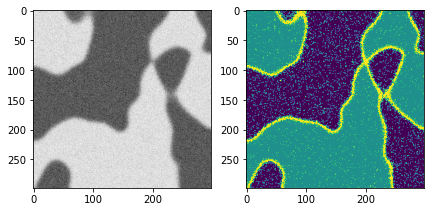

In [22]:
nMC_eval = 50
labeled_image = tools.evaluate_log_prob(model, image_to_segment_u, image_to_segment_v, nMC_eval, n_labels = 3)

print('\n All labels - one per model component \n')

fig, ax = plt.subplots(1, 2, figsize = (7,4))
ax[0].imshow(image_to_segment_u, cmap='Greys_r')
ax[1].imshow(labeled_image, cmap='viridis')
plt.show()

### Scatter plot voxels to illustrate how labels are determined

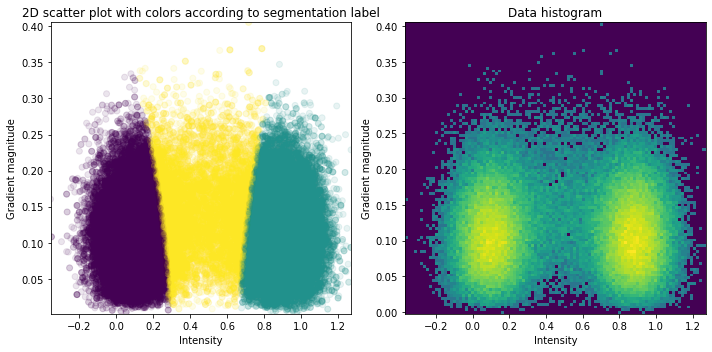

In [24]:
u_plot, v_plot = image_to_segment_u.numpy().ravel(), image_to_segment_v.numpy().ravel()
Ivals=np.linspace(np.min(u_plot), np.max(u_plot), 100)
Gvals=np.linspace(np.min(v_plot), np.max(v_plot), 100)
dI=Ivals[1]-Ivals[0]
dG=Gvals[1]-Gvals[0]

fig, ax = plt.subplots(1, 2, figsize = (10,5))
_ = tools.plot_2D_scatter_plot(u_plot, v_plot, colors = labeled_image.ravel(), 
                               n_samples = 100000, alpha = 0.1, xlim = [Ivals[0], Ivals[-1]], ylim = [Gvals[0], Gvals[-1]], fig_external = [fig, ax[0]],
                               xlabel='Intensity',ylabel='Gradient magnitude', title='2D scatter plot with colors according to segmentation label')

nbins_adj = np.concatenate([Ivals, np.array([(Ivals[-1]+dI)])])-0.5*dI, np.concatenate([Gvals, np.array([(Gvals[-1]+dG)])])-0.5*dG
im_data_hist = tools.plot_2D_histogram(u_plot, v_plot, cmap_gamma=0.2, fig_external = [fig, ax[1]],
                                       bins=nbins_adj, title='Data histogram', xlabel='Intensity', 
                                       ylabel='Gradient magnitude', cbar_label='Probability density', density=True, colorbar = False)